In [1]:
%run ./00_template.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


=== Template PEP1 Desiertos cargado ===
BASE_DIR        : /home/jovyan
CARGA_DIR       : /home/jovyan/data/raw/Carga de datos
RUTA_GPKG       : /home/jovyan/data/raw/Carga de datos/geodatabase_proyecto.gpkg
RUTA_CENSO_CSV  : /home/jovyan/data/raw/Carga de datos/censo_RM_totales_comuna.csv


In [2]:
from pathlib import Path
import shutil

src = Path("/home/jovyan/work/outputs/comunas_accessibility_otp.parquet")
dst_dir = Path("/home/jovyan/outputs")
dst_dir.mkdir(parents=True, exist_ok=True)

dst = dst_dir / src.name
shutil.copy2(src, dst)
print("✅ Copiado a:", dst, "exists:", dst.exists())


✅ Copiado a: /home/jovyan/outputs/comunas_accessibility_otp.parquet exists: True


In [3]:
from pathlib import Path
ACC_PATH = OUTPUTS_DIR / "comunas_accessibility_otp.parquet"
print("ACC_PATH:", ACC_PATH)
print("Existe?:", ACC_PATH.exists())

import pandas as pd
acc = pd.read_parquet(ACC_PATH)

print("acc shape:", acc.shape)
print("columnas:", acc.columns.tolist())

# Validaciones mínimas
assert len(acc) >= 10, f"❌ Dataset demasiado chico ({len(acc)} filas). Te falta calcular comunas en el notebook 03."
assert "cod_comuna" in acc.columns, "❌ Falta cod_comuna"
assert "comuna" in acc.columns, "❌ Falta comuna"

from pathlib import Path
import pandas as pd
import numpy as np

PARQ = OUTPUTS_DIR / "comunas_accessibility_otp.parquet"
LONG = OUTPUTS_DIR / "acc_long_partial.csv"

if PARQ.exists():
    acc = pd.read_parquet(PARQ)
else:
    acc = pd.DataFrame()

# Si el parquet existe pero está incompleto (1 fila), lo reconstruimos desde LONG
if len(acc) < 10:
    print(f"⚠️ Parquet incompleto (filas={len(acc)}). Reconstruyendo desde:", LONG)
    assert LONG.exists(), "❌ No existe acc_long_partial.csv. Vuelve al notebook 03 y genera el long."

    acc_long = pd.read_csv(LONG)

    # por seguridad: tipos
    acc_long["t_min_otp"] = pd.to_numeric(acc_long["t_min_otp"], errors="coerce")

    acc = acc_long.pivot_table(
        index=["cod_comuna", "comuna"],
        columns="categoria",
        values="t_min_otp",
        aggfunc="min"
    ).reset_index()

    # Guardamos parquet arreglado
    acc.to_parquet(PARQ, index=False)
    print("✅ Parquet reconstruido y guardado:", PARQ)

print("✅ acc final shape:", acc.shape)
acc.head()

acc["comuna"] = acc["comuna"].astype(str)




ACC_PATH: /home/jovyan/outputs/comunas_accessibility_otp.parquet
Existe?: True
acc shape: (48, 6)
columnas: ['cod_comuna', 'comuna', 'almacenes_barrio', 'educacion_superior', 'micro', 'salud']
✅ acc final shape: (48, 6)


In [4]:
acc.columns
acc.describe(include="all").T.head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cod_comuna,48.0,NaN,NaN,NaN,13242.645833,183.35415,13101.0,13112.75,13126.5,13402.25,13605.0
comuna,48,48,Santiago,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
almacenes_barrio,26.0,NaN,NaN,NaN,18.820513,33.018611,0.416667,2.6,5.225,13.504167,152.816667
educacion_superior,5.0,NaN,NaN,NaN,12.35,14.149264,1.666667,1.9,5.666667,17.716667,34.8
micro,33.0,NaN,NaN,NaN,7.885354,17.108618,0.5,1.216667,1.783333,4.066667,78.7
salud,32.0,NaN,NaN,NaN,31.633333,33.418986,2.533333,5.595833,26.266667,39.795833,132.466667


In [5]:
id_cols = {"cod_comuna", "comuna"}
features = [c for c in acc.columns if c not in id_cols and pd.api.types.is_numeric_dtype(acc[c])]
print("features:", features)

assert len(features) >= 2, f"❌ Necesitas >=2 features numéricas, tienes {len(features)}: {features}"
assert len(acc) >= 10, f"❌ Necesitas varias comunas, tienes {len(acc)}"



features: ['almacenes_barrio', 'educacion_superior', 'micro', 'salud']


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = acc[features].copy()

for c in features:
    X[c] = pd.to_numeric(X[c], errors="coerce")
    X[c] = X[c].fillna(X[c].quantile(0.9))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada (PC1, PC2):", pca.explained_variance_ratio_)


Varianza explicada (PC1, PC2): [0.43968542 0.23490699]


In [8]:
# Cargar indicadores socio-demográficos
ind = gpd.read_file(RUTA_GPKG, layer="comunas_rm_censo")

COLS_SOCIO = [
    "CUT_COM"
]

ind = ind[COLS_SOCIO].rename(columns={"CUT_COM": "cod_comuna"})

df = acc.merge(ind, on="cod_comuna", how="left")
df.head()


,cod_comuna,comuna,almacenes_barrio,educacion_superior,micro,salud
0,13101,Santiago,3.616667,1.9,1.216667,4.800000
1,13102,Cerrillos,6.333333,NaN,2.600000,NaN
2,13103,Cerro Navia,NaN,NaN,5.083333,10.183333
3,13104,Conchalí,NaN,NaN,0.566667,NaN
4,13105,El Bosque,NaN,NaN,4.883333,3.400000


In [9]:
FEATURES = [
    "salud",
    "micro",
    "almacenes_barrio",
    "educacion_superior",
]

X = df[FEATURES].copy()


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


,cod_comuna,comuna,poblacion,score_desierto_salud,es_desierto_salud,score_desierto_supermercados,es_desierto_supermercados
0,13502,Alhué,7768,2,1,3,1
1,13402,Buin,116969,0,0,3,1
2,13403,Calera de Tango,25491,0,0,0,0
3,13102,Cerrillos,85041,0,0,0,0
4,13103,Cerro Navia,127250,1,0,1,0


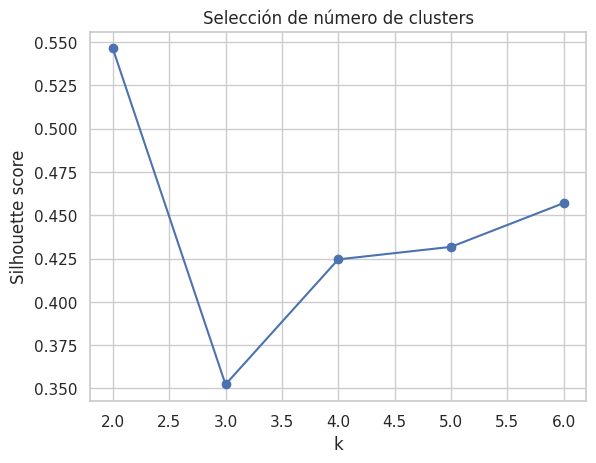

In [10]:
scores = []
K = range(2, 7)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.plot(K, scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Selección de número de clusters")
plt.show()


In [11]:
k_opt = 2  # ejemplo
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

df[["comuna", "cluster"]].head()


,comuna,cluster
0,Santiago,1
1,Cerrillos,0
2,Cerro Navia,0
3,Conchalí,0
4,El Bosque,0


In [12]:
cluster_profile = df.groupby("cluster")[FEATURES].mean()
cluster_profile


,salud,micro,almacenes_barrio,educacion_superior
cluster,,,,
0,33.491667,8.546111,20.950000,26.258333
1,3.758333,1.277778,2.494444,3.077778


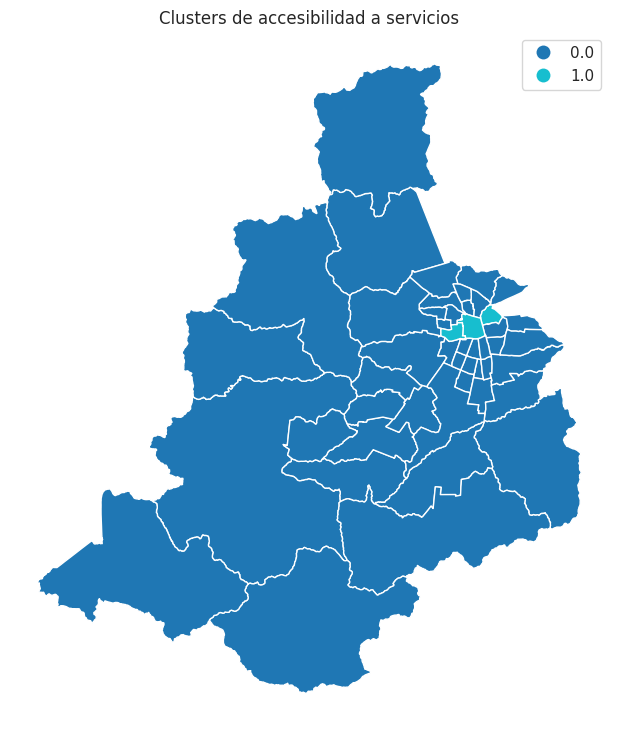

df cols: ['cod_comuna', 'comuna', 'almacenes_barrio', 'educacion_superior', 'micro', 'salud', 'cluster']
comunas_map cols: ['CUT_REG', 'CUT_PROV', 'cod_comuna', 'REGION', 'PROVINCIA', 'COMUNA', 'SUPERFICIE', 'Código comuna', 'Población censada', 'Hombres', 'Mujeres', 'geometry', 'cluster']


In [16]:
comunas_map = gpd.read_file(RUTA_GPKG, layer="comunas_rm_censo").copy()

# Dejar el mismo nombre de ID que usa df
comunas_map = comunas_map.rename(columns={"CUT_COM": "cod_comuna"})

# Asegurar mismo tipo (a veces uno viene int y el otro str)
comunas_map["cod_comuna"] = comunas_map["cod_comuna"].astype(str)
df["cod_comuna"] = df["cod_comuna"].astype(str)

comunas_map = comunas_map.merge(df[["cod_comuna", "cluster"]], on="cod_comuna", how="left")

fig, ax = plt.subplots(figsize=(9, 9))
comunas_map.plot(column="cluster", categorical=True, legend=True, ax=ax)
ax.set_title("Clusters de accesibilidad a servicios")
ax.set_axis_off()
plt.show()

print("df cols:", df.columns.tolist())
print("comunas_map cols:", comunas_map.columns.tolist())

